In [1]:
from IPython.display import clear_output
import time
from omegaconf import OmegaConf
import yaml
from taming.models.bert_transformer import BertTransformer
import torch
import yaml
from taming.models.cond_transformer import Net2NetTransformer
import torch
import numpy as np
from scipy import ndimage

##LOADING BERT
config_path = "/logs/2021-10-14T16-32-28_ffhq_transformer_bert_2D_6_deeper/configs/2021-10-14T16-32-28-project.yaml"
config = OmegaConf.load(config_path)
model = BertTransformer(**config.model.params)
ckpt_path = "/logs/2021-10-14T16-32-28_ffhq_transformer_bert_2D_6_deeper/checkpoints/epoch=000019.ckpt"
sd = torch.load(ckpt_path, map_location="cpu")["state_dict"]
missing, unexpected = model.load_state_dict(sd, strict=False)
model.cuda().eval()
torch.set_grad_enabled(True)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Restored from logs/2021-04-23T18-19-01_ffhq_transformer/checkpoints/vqgan.ckpt
Using no cond stage. Assuming the training is intended to be unconditional. Prepending 0 as a sos token.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Using no cond stage. Assuming the training is intended to be unconditional. Prepending 0 as a sos token.


## Load a dummy image

torch.Size([1, 3, 256, 256])
z_code torch.Size([1, 256, 16, 16]) torch.float32
z_indices torch.Size([1, 256]) torch.int64


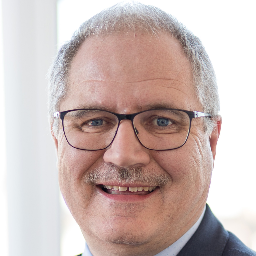

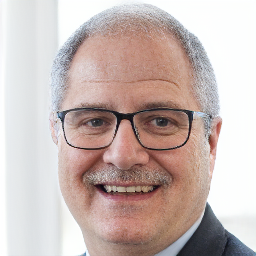

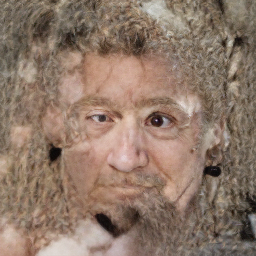

In [2]:
from PIL import Image
import numpy as np
img_path = "/data/ffhq/00306.png"
img = Image.open(img_path)
img = np.array(img)
img = torch.tensor(img.transpose(2,0,1)[None]).to(dtype=torch.float32, device=model.device)
img = img/127.5-1
img = torch.nn.functional.interpolate(img, size=(256))
print(img.shape)

def show_segmentation(s):
    s = s.detach().cpu().numpy().transpose(0,2,3,1)[0,:,:,None,:]
    s = s[...,0,:]
    s = s * 255
    s = s.clip(0,255).astype(np.uint8)
    s = Image.fromarray(s)
    display(s)
    
def show_image(s):
    s = s.detach().cpu().numpy().transpose(0,2,3,1)[0]
    s = ((s+1.0)*127.5).clip(0,255).astype(np.uint8)
    s = Image.fromarray(s)
    display(s)

z_code, z_indices = model.encode_to_z(img)
print("z_code", z_code.shape, z_code.dtype)
print("z_indices", z_indices.shape, z_indices.dtype)
assert z_code.shape[2]*z_code.shape[3] == z_indices.shape[1]
img_rec = model.first_stage_model.decode(z_code)

#Show a random image!!
codebook_size = config.model.params.first_stage_config.params.embed_dim
z_indices = torch.randint(codebook_size, z_indices.shape, device=model.device)
x_sample = model.decode_to_img(z_indices, z_code.shape)
show_image(img)
show_image(img_rec)
show_image(x_sample)

## Define utils functions

In [13]:
from IPython.display import clear_output
import time
import matplotlib.pyplot as plt
import torchvision

def show(img):
    npimg = img.cpu().numpy()
    npimg = np.clip(npimg, 0, 1)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def plt_save_image(images, textfile):
    plt.clf()
    width = 5*len(images)
    fig=plt.figure(figsize=(width, 10))
    for i in range(len(images)):
        ax = fig.add_subplot(1, len(images), i+1)
        ax.set_axis_off()
        show(images[i])
        
        if i ==0:
            autoAxis = ax.axis()
            rec = plt.Rectangle((autoAxis[0], autoAxis[2]),(autoAxis[1]-autoAxis[0])+1,(autoAxis[3]-autoAxis[2])+0.4, \
                                fill=False, lw=2, color='green')
            rec = ax.add_patch(rec)
            rec.set_clip_on(False)
        
    plt.tight_layout()
    plt.savefig('images/'+textfile+'.jpg', bbox_inches="tight")

def get_probs_si(logits, target, temperature, wasserstein=False):
    logits = logits[:, 1:,]
    target = target[:, 1:]
    logits = logits.squeeze(0)
    target = target.squeeze(0)
    probs = torch.nn.functional.softmax(logits, dim=1)    
    probs_si = torch.diag(-probs[:,target])
    probs_si_np = probs_si.detach().cpu().numpy()
    probs_si_np = probs_si_np/np.amax(np.abs(probs_si_np))
    
    #print(wasserstein, probs_si_np)
    probs_si_np /= temperature
    probs_si_np = np.exp(probs_si_np)/np.sum(np.exp(probs_si_np))
    return probs_si_np

def plt_save_image_and_heatmap(image, probs_si, image2=None, textfile=None, titles=None):
    plt.clf()
    fig=plt.figure(figsize=(8, 8))
    if image2 is not None:
        ax1 = fig.add_subplot(1, 3, 1)
        ax1.set_axis_off()
        show(image)
        ax2 = fig.add_subplot(1, 3, 2)
        plt.imshow(probs_si, cmap='coolwarm', interpolation='nearest')
        ax2.set_axis_off()    
        ax3 = fig.add_subplot(1, 3, 3)
        ax3.set_axis_off()
        show(image2)
        if titles is not None:
            ax1.set_title(titles[0])
            ax2.set_title(titles[1])
            ax3.set_title(titles[2])
    else:
        ax = fig.add_subplot(1, 2, 1)
        ax.set_axis_off()
        show(image)
        ax = fig.add_subplot(1, 2, 2)
        plt.imshow(probs_si, cmap='coolwarm', interpolation='nearest')
        ax.set_axis_off()
        if titles is not None:
            ax1.set_title(titles[0])
            ax2.set_title(titles[1])
            
    plt.tight_layout()
    plt.show()
    plt.savefig(textfile+".jpg")


## Improve image with BERT

In [14]:
def improve_image_with_bert_less_likely(seq, model, config, img, num, update_every, 
                                       num_steps, multiple_sampling, temperature, temperature_token):
    idx = seq
    _,c_indices = model.encode_to_c(img)
    cidx = c_indices
    start_t = time.time()
    patch = idx[:,:,:]
    patch = patch.reshape(patch.shape[0],-1)
    cpatch = cidx
    patch = patch[:,:]
    patch = torch.cat((cpatch, patch), dim=1)
    gen_images = list()
    
    for i in range(num_steps):
        logits,_ = model.transformer(patch)
        probs_si = get_probs_si(logits, patch, temperature)
        selected_idx = np.random.choice(np.arange(len(probs_si)), size=multiple_sampling, replace=False, p=probs_si)    
    
        for s_idx in selected_idx:
            logits_s_idx = logits[:, s_idx+1,:].squeeze(0)
            logits_s_idx /= temperature_token
            probs = torch.nn.functional.softmax(logits_s_idx, dim=0)
            new_idx = torch.multinomial(probs, num_samples=1)
            patch[:,s_idx+1] = new_idx
            
        if i==0:
            disp_patch = patch[:,-256:].reshape(z_code.shape[0],16,16)
            x_sample_0 = model.decode_to_img(disp_patch, z_code.shape)
            probs_si_0 = np.reshape(get_probs_si(logits, patch, temperature), (16, 16))
            gen_images.append(model.decode_to_img(disp_patch, z_code.shape))
            
    disp_patch = patch[:,-256:].reshape(z_code.shape[0],16,16)
    x_sample = model.decode_to_img(disp_patch, z_code.shape)
    plt_save_image_and_heatmap((x_sample_0[0]+1)/2, probs_si_0, (x_sample[0]+1)/2, \
                               textfile='test', titles=['Noisy image', 'Heatmap less likely', 'Correction by EdiBERT'])
    #show_image(x_sample)
    #images = torch.cat(gen_images, dim=0)
    #plt_save_image((images+1)/2, 'improvement'+str(num))

<Figure size 432x288 with 0 Axes>

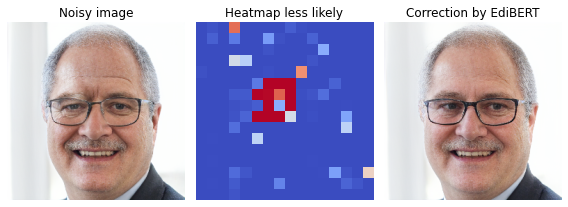

<Figure size 432x288 with 0 Axes>

In [17]:
for i in range(1):
    num_steps = 50
    update_every = 100
    multiple_sampling = 1
    temperature = 0.05
    temperature_token = 0.75
    size_of_perturbation_in_tokens = (4,4)
    _, seq_gpt = model.encode_to_z(img)
    seq_gpt = torch.reshape(seq_gpt, (1, 16, 16))
    seq_gpt[:, 5:5+size_of_perturbation_in_tokens[0], 5:5+size_of_perturbation_in_tokens[1]] = \
        torch.randint(1024, (1, size_of_perturbation_in_tokens[0], size_of_perturbation_in_tokens[1]))
    improve_image_with_bert_less_likely(seq_gpt, model, config, img, i, update_every, \
                                       num_steps, multiple_sampling, temperature, temperature_token)
    